In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import math
import csv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import pylab as plt
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from scipy.stats.stats import pearsonr   
from sklearn import linear_model, datasets
import itertools

In [2]:
#########################################################################
##[FUNCTION] data_creation simulates data for a given number of 
## individuals(indiv) over a set amount of time (max_time), and can 
## include as many covariates as desired (number_of_covariates)

## -- need to create the functionality for multiple covariates

#########################################################################


def data_creation2(indiv, max_time, number_of_covariates, Y_full, alpha, beta): 

    columns = ["indiv", "time","U", "A", "Y",  "L1"]
    df = pd.DataFrame(columns = columns)
     
    ## creating an unobserved variable that affects covariates 
    U = np.random.uniform(low = 0.1, high = 1, size = indiv)
            
    for jj in range(0, max_time+1): 
        if jj == 0: 
            x_L = alpha[0] + alpha[5]*U 
            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))

            x_A = beta[0] + beta[1]*L1 
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                 "Y":[math.nan]*indiv, "L1":L1})
            
        elif jj == 1: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"]\
                  [(df.time == jj-1)], [0.0]*indiv, df["A"][(df.time == jj-1)],\
                  [0.0]*indiv, U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv, L1, df["L1"]\
                  [(df.time == jj-1)],df["A"][(df.time == jj-1)], [0.0]*indiv ])), axis = 1)
                         
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj, "U":U, "A":A,\
                      "Y":[math.nan]*indiv, "L1":L1})
            df = pd.concat([df, temp_df])

        else: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"][(df.time == jj-1)], \
                  df["L1"][(df.time == jj-2)], df["A"][(df.time == jj-1)], \
                  df["A"][(df.time == jj-2)], U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv,L1,df["L1"][(df.time == jj-1)],\
                  df["A"][(df.time == jj-1)] , df["A"][(df.time == jj-2)]])), axis = 1)

            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            if jj == max_time: 
                x_Y = 0.5 + U 
                Y = np.random.binomial(n=1, p = np.exp(x_Y)/(1+np.exp(x_Y)))                
                temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                          "Y":Y, "L1":L1})
                df = pd.concat([df, temp_df])


            else: 
                temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                          "Y":[math.nan]*indiv, "L1":L1})
                df = pd.concat([df, temp_df])


    # creating shifted values 
    if Y_full == "TRUE":
        for kk in range(1,max_time+1):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
    else:
        for kk in range(1,4):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
            
    df.sort_values(by=['time', 'indiv'], ascending=[True, True])

    return(df); 

In [3]:
#########################################################################
##[FUNCTION] Y_model_creation creates the linear regression model for 
## the observed Ys based on the treatments (A) and covariates (L)  

#########################################################################

def Y_model_creation(df, max_time): 
    temp_df = df[df.time == max_time]
    # train_columns ='+'.join(map(str, np.append(list(df)[0:2],list(df)[6:])))
    train_columns = list(df)[0:2]+list(df)[6:]
    temp_df = temp_df.astype(float)
    # Y_model = smf.ols("Y~"+train_columns, data=temp_df).fit(); 
    Y_model = sm.Logit(np.asarray(temp_df["Y"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
    return(Y_model)

In [4]:
#########################################################################
##[FUNCTION] covariate_model_creation creates the logistic regression 
## for the observed covariate (L) data from the previous covariates 
## and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
## SHOULD THIS BE FOR ALL HISTORY UP TO THAT POINT TO BE MORE 
## ACCURATE WHEN CALCULATING THE EXPECTATION??? 

#########################################################################


def covariate_model_creation(df, max_time): 
    columns = ["time", "gamma_0", "gamma_1", "gamma_2", "gamma_3", "gamma_4", \
              "gamma_5", "gamma_6"]
    train_columns = ["L1_1", "L1_2", "L1_3", "A_1", "A_2",  "A_3"]
    L1_model_df = pd.DataFrame(columns = columns)

    for ii in range(1, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 1: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[["L1_1", "A_1"]]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + \
                         [L1_model.params[i] for i in range(0,2)] + ["Nan"] + \
                         ["Nan"] + [L1_model.params[2]] + ["Nan"] + ["Nan"], \
                         index = columns).transpose(), ignore_index=True)
        elif ii == 2: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[["L1_1", "L1_2", \
                       "A_1", "A_2"]]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + [L1_model.params[i] \
                          for i in range(0,3)] + ["Nan"] + [L1_model.params[i] for i \
                          in range(3,5)] + ["Nan"], index = columns).transpose(), \
                          ignore_index=True)
        else: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + [L1_model.params[i] for \
                          i in range(0,7)], index = columns).transpose(), \
                          ignore_index=True)
    return(L1_model_df)

In [5]:
#########################################################################
##[FUNCTION] treatment_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
#########################################################################


def treatment_model_creation(df, max_time): 
    columns = ["time", "zeta_0", "zeta_1", "zeta_2", "zeta_3", "zeta_4"]
    train_columns = ["L1", "L1_1", "A_1", "A_2"]
    A_model_df = pd.DataFrame(columns = columns)

    for ii in range(1, (max_time+1)): 
        temp_df = df[df.time == ii]   
        if ii == 1: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "A_1"]]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,4)] + ["Nan"], index = columns).transpose(),\
                         ignore_index=True)
        else: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[train_columns]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,5)],index = columns).transpose(), \
                         ignore_index=True)
    return(A_model_df)


In [6]:
#########################################################################
##[FUNCTION] simulation_run calculates the causal effect over an  
## established number of repetitions using the models for outcome (Y) 
## and the covariates (L) 

## -- need to create the functionality for multiple covariates

#########################################################################


def simulation_run2(df, Y_model, L1_model_df, max_time, Y_full, test_value): 
    reps = 10000
    final_results = np.empty(reps) 

    ### establishing treatment of interest
    A_test = [test_value]*(max_time+1) 

    values = pd.DataFrame(np.random.choice(np.array(df["L1"][df["time"] == 0]), reps))
    prod = np.empty(reps) 
    
    prod[np.where(values[0] == 0)] = 1-np.mean(list(df["L1"][df["time"] == 0]))
    prod[np.where(values[0] != 0)] = np.mean(list(df["L1"][df["time"] == 0]))

    values[1] = np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                np.array([[1.0]*reps,list(values[0]),[A_test[0]]*reps])), axis = 1)
    p_v = np.exp(values[1])/(1+np.exp(values[1]))
    values[1] = np.random.binomial(n=1, p = p_v)
    prod = prod*p_v
    
    values[2] = np.sum(np.array([L1_model_df.ix[1,][i] for i in [1,2,3,5,6]])*\
                np.transpose(np.array([[1.0]*reps, list(values[1]),list(values[0]), \
                [A_test[1]]*reps, [A_test[0]]*reps])), axis = 1 )
    p_v = (np.exp(values[2])/(1+np.exp(values[2]))) 
    values[2] = np.random.binomial(n=1, p=p_v)
    prod = prod*p_v
    
                                                               

    for jj in range(3, max_time+1):
        values[jj] = np.sum(np.array([L1_model_df.ix[jj-1,][i] for i in range(1,8)])\
                     *np.transpose(np.array([[1.0]*reps,list(values[jj-1]),\
                     list(values[jj-2]), list(values[jj-2]), [A_test[jj-1]]*reps, \
                     [A_test[jj-2]]*reps, [A_test[jj-3]]*reps])), axis = 1)
        p_v = (np.exp(values[jj])/(1+np.exp(values[jj]))) 
        values[jj] = np.random.binomial(n=1, p=p_v)
        prod = prod*p_v

    if Y_full == "TRUE": 
        Y_A = [A_test]*reps
        Y_L = np.array(values)
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8,10,12,14,16,18,20,22,24]]), \
                axis = 1)+np.sum([Y_model.params[i] for i in \
                [2,3,5,7,9,11,13,15,17,19,21,23]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))
        
    else: 
        Y_A = [A_test*4]*reps
        Y_L = np.array([values[0], values[1], values[2], values[3], values[4]])
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8]]), axis = 1)+np.sum(\
                [Y_model.params[i] for i in [2,3,5,7]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))

    return(np.mean(prod*Y_exp)) 

In [84]:
#########################################################################
##[FUNCTION] pi_function creates the w_m function given the following:
## the alpha model of A_{m,i}, the dataframe, the time (m), and an 
## indicator of whether this is the correct or incorrect model 

## do I need to do something in here like 1-expit for those A_j == 0?? 
## i.e. what I did in the last line here 
#########################################################################

def pi_function(m, alpha_model, df, indiv, alpha_wrong): 
    product = [1]*indiv
    for jj in range(2, m+1): 
        if alpha_wrong == False: 
            x = alpha_model.predict(sm.add_constant(df[df.time == jj][["L1", "L1_1", "A_1", \
                "A_2"]], has_constant='add'))
        else: 
            x = alpha_model.predict(sm.add_constant(df[df.time == jj][["L1_3", \
                "A_3"]], has_constant='add'))
        product = product*x
    
    x = np.array(np.divide([1]*indiv, product))
    x[np.where(df[df.time == m]["A_1"] == 0.0)] = 1 - x[np.where(df[df.time == m]["A_1"] == 0.0)]
    return(x)    

In [72]:
#########################################################################
##[FUNCTION] alpha_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) over all time periods and
## individuals 

## -- need to create the functionality for multiple covariates
#########################################################################


def alpha_model_creation(df, wrong): 
    temp_df = df[df["time"]>2.0]
    if wrong == True:
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1_3", "A_3"]], has_constant='add'))).fit()

    else: 
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "A_1", "A_2"]], has_constant='add'))).fit()

    return(alpha_model)  

In [9]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]

    while(time_counter > 3.0): 
        
        time_df = df.loc[df.time == time_counter-1]
        time_df["T"] = np.array(T)
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi 
        if wrong_s_model == "TRUE":
            train_columns = list(time_df)[0:1]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1],["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
            y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
            z = '+'.join(map(str, y))
            reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
            reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))

        time_df = time_df.astype(float)
        S_model = smf.ols("T~"+reg_columns, data=time_df).fit()
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "A_1", \
                    "A_2"]], has_constant = "add"))
                
        elif test_value == 0: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "A_1", "A_2"]], has_constant = "add")))

        time_df["pi"] = pi2
        T = sp.special.expit(S_model.predict(time_df[train_columns]))
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    
    return(np.nanmean(T), values)  

In [82]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model == True:
            train_columns = list(time_df)[0:1] + list(time_df)[12:14]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1],np.append(list(time_df)[12:14], ["pi"]))))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
            y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
            z = '+'.join(map(str, y))
            reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
            reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
        time_df = time_df.astype(float)

        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == True:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model == True:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    
    return(np.nanmean(T), values)  

In [17]:
## NEW OFFICIAL ALPHA AND BETA FOR EVERYTHING 
# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
# ALPHA = [ 0.58986656  0.95344212 -0.89822429 -0.95566697  0.67520365  2.46365403]
# BETA = [ 0.17868818  0.89069712  0.89037635  0.20497534  0.10442911]

In [85]:
indiv = 1000 
max_time = 11
num_sims = 10
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]
df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
alpha_model = alpha_model_creation(df,False)
[treatdr1, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model)
[treatdr0, values] =  DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model)
treatdr1 - treatdr0

Optimization terminated successfully.
         Current function value: 0.409421
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-0.018681009066687126

In [93]:
## CONSTANTS 
# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 1000
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

results_dr_bin_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference", \
                "meanY", "meanA", "meanL1","meanU","corrYA", "corrYL1", "corrYU", \
                "corrAL1", "corrUL1", "corrAU"])

results_g_form_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])


for ii in range(0, num_sims): 
    print(ii) 
    
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
    Y_model = Y_model_creation(df, max_time)
    L1_model_df = covariate_model_creation(df, max_time)
    treatg1 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 1)
    treatg0 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 0)
    results_g_form_df.loc[len(results_g_form_df+1)] = [treatg1, treatg0, treatg1-treatg0]

    df = df.iloc[:,0:12]
    alpha_model = alpha_model_creation(df,False)
    [treatdr1, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model)
    [treatdr0, values0] = DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model)
    results_dr_bin_df.loc[len(results_dr_bin_df+1)] = [treatdr1, treatdr0, treatdr1-treatdr0]+list(values)

results_g_form_df.to_csv("G_FORM_RESULTS_FINAL")
results_dr_bin_df.to_csv("DR_BIN_EST_RESULTS_FINAL")

0
Optimization terminated successfully.
         Current function value: 0.583759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474170


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.578329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479341


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.566945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454448


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.558613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489110


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.573077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455836


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.528345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445638


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.587204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479660


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.564405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446228


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.584268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470797


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.580812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449740


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.581002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462632

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.548882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.538795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478378

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.573943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449497

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.535835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.537594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477990

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.555507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447330

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.560887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473605

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.569112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.550002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479342

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.578717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.567792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.345279
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.566485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.429414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480799

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.585830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506506

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.571568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468411

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



25
Optimization terminated successfully.
         Current function value: 0.557918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447987

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



26
Optimization terminated successfully.
         Current function value: 0.564129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464266

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



27
Optimization terminated successfully.
         Current function value: 0.566681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.440090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450208

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



28
Optimization terminated successfully.
         Current function value: 0.597220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501436

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



29
Optimization terminated successfully.
         Current function value: 0.560793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455132

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



30
Optimization terminated successfully.
         Current function value: 0.572076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



31
Optimization terminated successfully.
         Current function value: 0.525604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467643

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



32
Optimization terminated successfully.
         Current function value: 0.547874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



33
Optimization terminated successfully.
         Current function value: 0.535869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



34
Optimization terminated successfully.
         Current function value: 0.574572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



35
Optimization terminated successfully.
         Current function value: 0.584258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.440889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474681

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



36
Optimization terminated successfully.
         Current function value: 0.578843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454355

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



37
Optimization terminated successfully.
         Current function value: 0.530224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465691

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



38
Optimization terminated successfully.
         Current function value: 0.567369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476799

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



39
Optimization terminated successfully.
         Current function value: 0.542656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



40
Optimization terminated successfully.
         Current function value: 0.581015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



41
Optimization terminated successfully.
         Current function value: 0.555197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426334

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



42
Optimization terminated successfully.
         Current function value: 0.570511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481763

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



43
Optimization terminated successfully.
         Current function value: 0.582761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459845

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



44
Optimization terminated successfully.
         Current function value: 0.569048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



45
Optimization terminated successfully.
         Current function value: 0.548935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460472

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



46
Optimization terminated successfully.
         Current function value: 0.560787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



47
Optimization terminated successfully.
         Current function value: 0.548593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472569

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



48
Optimization terminated successfully.
         Current function value: 0.534021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486168

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



49
Optimization terminated successfully.
         Current function value: 0.552588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484010

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



50
Optimization terminated successfully.
         Current function value: 0.536484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



51
Optimization terminated successfully.
         Current function value: 0.544549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350943
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480608

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



52
Optimization terminated successfully.
         Current function value: 0.535381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



53
Optimization terminated successfully.
         Current function value: 0.562488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445239

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



54
Optimization terminated successfully.
         Current function value: 0.574420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472131

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



55
Optimization terminated successfully.
         Current function value: 0.556427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499581

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



56
Optimization terminated successfully.
         Current function value: 0.581856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497519

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



57
Optimization terminated successfully.
         Current function value: 0.544643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466016

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



58
Optimization terminated successfully.
         Current function value: 0.559441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493934

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



59
Optimization terminated successfully.
         Current function value: 0.564883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456476

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



60
Optimization terminated successfully.
         Current function value: 0.561838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



61
Optimization terminated successfully.
         Current function value: 0.558782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



62
Optimization terminated successfully.
         Current function value: 0.601615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475012

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



63
Optimization terminated successfully.
         Current function value: 0.553385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472185

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



64
Optimization terminated successfully.
         Current function value: 0.570775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473049

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



65
Optimization terminated successfully.
         Current function value: 0.541318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464021

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



66
Optimization terminated successfully.
         Current function value: 0.579194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472815

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



67
Optimization terminated successfully.
         Current function value: 0.559268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.464286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461098

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



68
Optimization terminated successfully.
         Current function value: 0.582834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439811

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



69
Optimization terminated successfully.
         Current function value: 0.570956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462337

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



70
Optimization terminated successfully.
         Current function value: 0.561751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.500136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451597

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



71
Optimization terminated successfully.
         Current function value: 0.574410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470556

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



72
Optimization terminated successfully.
         Current function value: 0.574117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460670

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



73
Optimization terminated successfully.
         Current function value: 0.578725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473074

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



74
Optimization terminated successfully.
         Current function value: 0.554046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443659

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



75
Optimization terminated successfully.
         Current function value: 0.556642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478128

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



76
Optimization terminated successfully.
         Current function value: 0.563089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.435373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428878

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



77
Optimization terminated successfully.
         Current function value: 0.540078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474515

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



78
Optimization terminated successfully.
         Current function value: 0.569117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476184

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



79
Optimization terminated successfully.
         Current function value: 0.559124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436905

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



80
Optimization terminated successfully.
         Current function value: 0.572157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.440451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



81
Optimization terminated successfully.
         Current function value: 0.566799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453263

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



82
Optimization terminated successfully.
         Current function value: 0.567861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465244

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



83
Optimization terminated successfully.
         Current function value: 0.570037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465483

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



84
Optimization terminated successfully.
         Current function value: 0.546093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467137

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



85
Optimization terminated successfully.
         Current function value: 0.556867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



86
Optimization terminated successfully.
         Current function value: 0.560456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



87
Optimization terminated successfully.
         Current function value: 0.581225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480569

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



88
Optimization terminated successfully.
         Current function value: 0.543029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461380

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



89
Optimization terminated successfully.
         Current function value: 0.579610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466364

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



90
Optimization terminated successfully.
         Current function value: 0.554923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447970

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



91
Optimization terminated successfully.
         Current function value: 0.571912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479938

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



92
Optimization terminated successfully.
         Current function value: 0.556199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



93
Optimization terminated successfully.
         Current function value: 0.535049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471532

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



94
Optimization terminated successfully.
         Current function value: 0.565207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443693

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



95
Optimization terminated successfully.
         Current function value: 0.583458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439787

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



96
Optimization terminated successfully.
         Current function value: 0.565823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450076

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



97
Optimization terminated successfully.
         Current function value: 0.560678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



98
Optimization terminated successfully.
         Current function value: 0.553714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460278

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



99
Optimization terminated successfully.
         Current function value: 0.574873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460695

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



100
Optimization terminated successfully.
         Current function value: 0.560533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47170

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



101
Optimization terminated successfully.
         Current function value: 0.574976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47933

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



102
Optimization terminated successfully.
         Current function value: 0.545609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46096

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



103
Optimization terminated successfully.
         Current function value: 0.554721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



104
Optimization terminated successfully.
         Current function value: 0.571171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.436559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47027

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



105
Optimization terminated successfully.
         Current function value: 0.568322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.48105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



106
Optimization terminated successfully.
         Current function value: 0.570814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



107
Optimization terminated successfully.
         Current function value: 0.574423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.444093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47166

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



108
Optimization terminated successfully.
         Current function value: 0.546504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49965

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



109
Optimization terminated successfully.
         Current function value: 0.565563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



110
Optimization terminated successfully.
         Current function value: 0.563801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40241

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



111
Optimization terminated successfully.
         Current function value: 0.566321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45358

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



112
Optimization terminated successfully.
         Current function value: 0.537576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



113
Optimization terminated successfully.
         Current function value: 0.580896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45012

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



114
Optimization terminated successfully.
         Current function value: 0.521814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46553

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



115
Optimization terminated successfully.
         Current function value: 0.565756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46455

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



116
Optimization terminated successfully.
         Current function value: 0.565819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46462

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



117
Optimization terminated successfully.
         Current function value: 0.531973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45387

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



118
Optimization terminated successfully.
         Current function value: 0.589207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



119
Optimization terminated successfully.
         Current function value: 0.556998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47796

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



120
Optimization terminated successfully.
         Current function value: 0.546595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



121
Optimization terminated successfully.
         Current function value: 0.547051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45067

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



122
Optimization terminated successfully.
         Current function value: 0.578828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48130

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



123
Optimization terminated successfully.
         Current function value: 0.577624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45742

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



124
Optimization terminated successfully.
         Current function value: 0.570054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45805

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



125
Optimization terminated successfully.
         Current function value: 0.550400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45919

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



126
Optimization terminated successfully.
         Current function value: 0.574482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44669

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



127
Optimization terminated successfully.
         Current function value: 0.555823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46624

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



128
Optimization terminated successfully.
         Current function value: 0.567685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44819

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



129
Optimization terminated successfully.
         Current function value: 0.563727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47234

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



130
Optimization terminated successfully.
         Current function value: 0.551981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



131
Optimization terminated successfully.
         Current function value: 0.560243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48832

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



132
Optimization terminated successfully.
         Current function value: 0.547578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48808

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



133
Optimization terminated successfully.
         Current function value: 0.545689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



134
Optimization terminated successfully.
         Current function value: 0.568355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45432

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



135
Optimization terminated successfully.
         Current function value: 0.560658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44397

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



136
Optimization terminated successfully.
         Current function value: 0.579353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.426922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48709

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



137
Optimization terminated successfully.
         Current function value: 0.533850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



138
Optimization terminated successfully.
         Current function value: 0.596424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



139
Optimization terminated successfully.
         Current function value: 0.589255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46755

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



140
Optimization terminated successfully.
         Current function value: 0.561198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44603

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



141
Optimization terminated successfully.
         Current function value: 0.544280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46867

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



142
Optimization terminated successfully.
         Current function value: 0.570884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



143
Optimization terminated successfully.
         Current function value: 0.572778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46760

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



144
Optimization terminated successfully.
         Current function value: 0.590985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49266

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



145
Optimization terminated successfully.
         Current function value: 0.571258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45622

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



146
Optimization terminated successfully.
         Current function value: 0.554341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



147
Optimization terminated successfully.
         Current function value: 0.557430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



148
Optimization terminated successfully.
         Current function value: 0.584217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45562

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



149
Optimization terminated successfully.
         Current function value: 0.524348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



150
Optimization terminated successfully.
         Current function value: 0.562511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45292

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



151
Optimization terminated successfully.
         Current function value: 0.553749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47078

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



152
Optimization terminated successfully.
         Current function value: 0.583511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47636

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



153
Optimization terminated successfully.
         Current function value: 0.542938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42651

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



154
Optimization terminated successfully.
         Current function value: 0.573665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



155
Optimization terminated successfully.
         Current function value: 0.557774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44967

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



156
Optimization terminated successfully.
         Current function value: 0.565737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46342

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



157
Optimization terminated successfully.
         Current function value: 0.564060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45074

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



158
Optimization terminated successfully.
         Current function value: 0.559385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



159
Optimization terminated successfully.
         Current function value: 0.564565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44687

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



160
Optimization terminated successfully.
         Current function value: 0.563862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



161
Optimization terminated successfully.
         Current function value: 0.577281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



162
Optimization terminated successfully.
         Current function value: 0.522197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



163
Optimization terminated successfully.
         Current function value: 0.558719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46088

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



164
Optimization terminated successfully.
         Current function value: 0.561398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



165
Optimization terminated successfully.
         Current function value: 0.573310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



166
Optimization terminated successfully.
         Current function value: 0.551836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



167
Optimization terminated successfully.
         Current function value: 0.572631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46087

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



168
Optimization terminated successfully.
         Current function value: 0.598407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47813

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



169
Optimization terminated successfully.
         Current function value: 0.556015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46218

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



170
Optimization terminated successfully.
         Current function value: 0.565119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48662

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



171
Optimization terminated successfully.
         Current function value: 0.600050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46369

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



172
Optimization terminated successfully.
         Current function value: 0.591123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



173
Optimization terminated successfully.
         Current function value: 0.540944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49941

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



174
Optimization terminated successfully.
         Current function value: 0.540522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45524

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



175
Optimization terminated successfully.
         Current function value: 0.581964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.427505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



176
Optimization terminated successfully.
         Current function value: 0.563882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



177
Optimization terminated successfully.
         Current function value: 0.557544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45584

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



178
Optimization terminated successfully.
         Current function value: 0.547474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46743

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



179
Optimization terminated successfully.
         Current function value: 0.561594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46271

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



180
Optimization terminated successfully.
         Current function value: 0.579279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



181
Optimization terminated successfully.
         Current function value: 0.570576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46314

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



182
Optimization terminated successfully.
         Current function value: 0.575597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.499406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47544

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



183
Optimization terminated successfully.
         Current function value: 0.564039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41542

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



184
Optimization terminated successfully.
         Current function value: 0.554521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43371

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



185
Optimization terminated successfully.
         Current function value: 0.556782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.431063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



186
Optimization terminated successfully.
         Current function value: 0.561411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42274

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



187
Optimization terminated successfully.
         Current function value: 0.574638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46043

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



188
Optimization terminated successfully.
         Current function value: 0.538695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47676

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



189
Optimization terminated successfully.
         Current function value: 0.581742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45929

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



190
Optimization terminated successfully.
         Current function value: 0.544334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.430593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



191
Optimization terminated successfully.
         Current function value: 0.559333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



192
Optimization terminated successfully.
         Current function value: 0.569475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45062

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



193
Optimization terminated successfully.
         Current function value: 0.557020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47164

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



194
Optimization terminated successfully.
         Current function value: 0.551834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46556

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



195
Optimization terminated successfully.
         Current function value: 0.569974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.487394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47020

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



196
Optimization terminated successfully.
         Current function value: 0.568787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.444443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44293

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



197
Optimization terminated successfully.
         Current function value: 0.567743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.500298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



198
Optimization terminated successfully.
         Current function value: 0.590453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



199
Optimization terminated successfully.
         Current function value: 0.540599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



200
Optimization terminated successfully.
         Current function value: 0.563717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44732

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



201
Optimization terminated successfully.
         Current function value: 0.576878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.436266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46250

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



202
Optimization terminated successfully.
         Current function value: 0.601585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46628

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



203
Optimization terminated successfully.
         Current function value: 0.549164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.48231

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



204
Optimization terminated successfully.
         Current function value: 0.569525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



205
Optimization terminated successfully.
         Current function value: 0.567463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47628

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



206
Optimization terminated successfully.
         Current function value: 0.564901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



207
Optimization terminated successfully.
         Current function value: 0.536232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47043

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



208
Optimization terminated successfully.
         Current function value: 0.567580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48454

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



209
Optimization terminated successfully.
         Current function value: 0.559504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.428359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45799

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



210
Optimization terminated successfully.
         Current function value: 0.556944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.464262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47263

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



211
Optimization terminated successfully.
         Current function value: 0.532703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



212
Optimization terminated successfully.
         Current function value: 0.541822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



213
Optimization terminated successfully.
         Current function value: 0.570036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47833

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



214
Optimization terminated successfully.
         Current function value: 0.577840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46460

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



215
Optimization terminated successfully.
         Current function value: 0.574958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377383
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45318

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



216
Optimization terminated successfully.
         Current function value: 0.560530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.431497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46132

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



217
Optimization terminated successfully.
         Current function value: 0.569190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46457

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



218
Optimization terminated successfully.
         Current function value: 0.575925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



219
Optimization terminated successfully.
         Current function value: 0.581579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.440466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45095

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



220
Optimization terminated successfully.
         Current function value: 0.548251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



221
Optimization terminated successfully.
         Current function value: 0.560842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47348

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



222
Optimization terminated successfully.
         Current function value: 0.574490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



223
Optimization terminated successfully.
         Current function value: 0.573285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45745

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



224
Optimization terminated successfully.
         Current function value: 0.555132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44963

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



225
Optimization terminated successfully.
         Current function value: 0.552568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47636

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



226
Optimization terminated successfully.
         Current function value: 0.568048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43876

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



227
Optimization terminated successfully.
         Current function value: 0.564505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



228
Optimization terminated successfully.
         Current function value: 0.551584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



229
Optimization terminated successfully.
         Current function value: 0.543097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46694

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



230
Optimization terminated successfully.
         Current function value: 0.561097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45343

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



231
Optimization terminated successfully.
         Current function value: 0.563425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48043

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



232
Optimization terminated successfully.
         Current function value: 0.550258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45700

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



233
Optimization terminated successfully.
         Current function value: 0.562119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.441782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44548

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



234
Optimization terminated successfully.
         Current function value: 0.553708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45001

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



235
Optimization terminated successfully.
         Current function value: 0.575795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



236
Optimization terminated successfully.
         Current function value: 0.566295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44131

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



237
Optimization terminated successfully.
         Current function value: 0.569173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47086

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



238
Optimization terminated successfully.
         Current function value: 0.578941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46539

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



239
Optimization terminated successfully.
         Current function value: 0.539381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



240
Optimization terminated successfully.
         Current function value: 0.558193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48328

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



241
Optimization terminated successfully.
         Current function value: 0.590733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47275

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



242
Optimization terminated successfully.
         Current function value: 0.569447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43706

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



243
Optimization terminated successfully.
         Current function value: 0.559241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45973

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



244
Optimization terminated successfully.
         Current function value: 0.573536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45843

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



245
Optimization terminated successfully.
         Current function value: 0.547729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46613

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



246
Optimization terminated successfully.
         Current function value: 0.560036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



247
Optimization terminated successfully.
         Current function value: 0.567411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45202

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



248
Optimization terminated successfully.
         Current function value: 0.535047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49032

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



249
Optimization terminated successfully.
         Current function value: 0.534382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50411

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



250
Optimization terminated successfully.
         Current function value: 0.562286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



251
Optimization terminated successfully.
         Current function value: 0.565891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.432773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43862

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



252
Optimization terminated successfully.
         Current function value: 0.560404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45661

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



253
Optimization terminated successfully.
         Current function value: 0.570234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47765

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



254
Optimization terminated successfully.
         Current function value: 0.565122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41759

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



255
Optimization terminated successfully.
         Current function value: 0.575697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46406

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



256
Optimization terminated successfully.
         Current function value: 0.553845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46222

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



257
Optimization terminated successfully.
         Current function value: 0.545488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44395

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



258
Optimization terminated successfully.
         Current function value: 0.565087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



259
Optimization terminated successfully.
         Current function value: 0.542901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48086

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



260
Optimization terminated successfully.
         Current function value: 0.550515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47180

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



261
Optimization terminated successfully.
         Current function value: 0.578891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45695

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



262
Optimization terminated successfully.
         Current function value: 0.560431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



263
Optimization terminated successfully.
         Current function value: 0.553511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47078

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



264
Optimization terminated successfully.
         Current function value: 0.569936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49569

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



265
Optimization terminated successfully.
         Current function value: 0.545692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44447

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



266
Optimization terminated successfully.
         Current function value: 0.586710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43935

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



267
Optimization terminated successfully.
         Current function value: 0.575988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45692

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



268
Optimization terminated successfully.
         Current function value: 0.573508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



269
Optimization terminated successfully.
         Current function value: 0.568380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46085

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



270
Optimization terminated successfully.
         Current function value: 0.566548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



271
Optimization terminated successfully.
         Current function value: 0.567297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44204

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



272
Optimization terminated successfully.
         Current function value: 0.578090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.430701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



273
Optimization terminated successfully.
         Current function value: 0.597468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45728

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



274
Optimization terminated successfully.
         Current function value: 0.566608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49442

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



275
Optimization terminated successfully.
         Current function value: 0.561621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46163

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



276
Optimization terminated successfully.
         Current function value: 0.583390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.357711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45882

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



277
Optimization terminated successfully.
         Current function value: 0.574163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46278

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



278
Optimization terminated successfully.
         Current function value: 0.539587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45207

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



279
Optimization terminated successfully.
         Current function value: 0.565454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44675

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



280
Optimization terminated successfully.
         Current function value: 0.566768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44502

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



281
Optimization terminated successfully.
         Current function value: 0.535835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43551

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



282
Optimization terminated successfully.
         Current function value: 0.554015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47938

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



283
Optimization terminated successfully.
         Current function value: 0.563558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



284
Optimization terminated successfully.
         Current function value: 0.554247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



285
Optimization terminated successfully.
         Current function value: 0.570903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



286
Optimization terminated successfully.
         Current function value: 0.531214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46973

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



287
Optimization terminated successfully.
         Current function value: 0.538614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47512

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



288
Optimization terminated successfully.
         Current function value: 0.558857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.433132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



289
Optimization terminated successfully.
         Current function value: 0.567210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44800

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



290
Optimization terminated successfully.
         Current function value: 0.569771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



291
Optimization terminated successfully.
         Current function value: 0.581006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47614

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



292
Optimization terminated successfully.
         Current function value: 0.558858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48656

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



293
Optimization terminated successfully.
         Current function value: 0.552914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49512

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



294
Optimization terminated successfully.
         Current function value: 0.575609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48730

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



295
Optimization terminated successfully.
         Current function value: 0.579659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47316

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



296
Optimization terminated successfully.
         Current function value: 0.553946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45655

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



297
Optimization terminated successfully.
         Current function value: 0.563368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46664

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



298
Optimization terminated successfully.
         Current function value: 0.574527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46128

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



299
Optimization terminated successfully.
         Current function value: 0.535669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44711

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



300
Optimization terminated successfully.
         Current function value: 0.566056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44233

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



301
Optimization terminated successfully.
         Current function value: 0.560031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45506

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



302
Optimization terminated successfully.
         Current function value: 0.579357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



303
Optimization terminated successfully.
         Current function value: 0.569292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44483

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



304
Optimization terminated successfully.
         Current function value: 0.557663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48243

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



305
Optimization terminated successfully.
         Current function value: 0.553527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



306
Optimization terminated successfully.
         Current function value: 0.567254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47365

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



307
Optimization terminated successfully.
         Current function value: 0.547493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46760

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



308
Optimization terminated successfully.
         Current function value: 0.576589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47234

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



309
Optimization terminated successfully.
         Current function value: 0.567675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48669

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



310
Optimization terminated successfully.
         Current function value: 0.577307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



311
Optimization terminated successfully.
         Current function value: 0.530388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45351

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



312
Optimization terminated successfully.
         Current function value: 0.572741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.440697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47558

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



313
Optimization terminated successfully.
         Current function value: 0.563245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



314
Optimization terminated successfully.
         Current function value: 0.577565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



315
Optimization terminated successfully.
         Current function value: 0.552562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



316
Optimization terminated successfully.
         Current function value: 0.553692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



317
Optimization terminated successfully.
         Current function value: 0.564032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47391

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



318
Optimization terminated successfully.
         Current function value: 0.575673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



319
Optimization terminated successfully.
         Current function value: 0.573523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.39817

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



320
Optimization terminated successfully.
         Current function value: 0.578267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48432

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



321
Optimization terminated successfully.
         Current function value: 0.554591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



322
Optimization terminated successfully.
         Current function value: 0.552928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



323
Optimization terminated successfully.
         Current function value: 0.580405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45351

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



324
Optimization terminated successfully.
         Current function value: 0.571029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45745

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



325
Optimization terminated successfully.
         Current function value: 0.574542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50329

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



326
Optimization terminated successfully.
         Current function value: 0.568568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



327
Optimization terminated successfully.
         Current function value: 0.579699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.49402

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



328
Optimization terminated successfully.
         Current function value: 0.559745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43658

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



329
Optimization terminated successfully.
         Current function value: 0.548079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



330
Optimization terminated successfully.
         Current function value: 0.558203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48568

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



331
Optimization terminated successfully.
         Current function value: 0.556045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46240

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



332
Optimization terminated successfully.
         Current function value: 0.572002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44844

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



333
Optimization terminated successfully.
         Current function value: 0.581669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50406

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



334
Optimization terminated successfully.
         Current function value: 0.581182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44258

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



335
Optimization terminated successfully.
         Current function value: 0.565714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



336
Optimization terminated successfully.
         Current function value: 0.564559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48685

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



337
Optimization terminated successfully.
         Current function value: 0.573031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44662

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



338
Optimization terminated successfully.
         Current function value: 0.585960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47674

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



339
Optimization terminated successfully.
         Current function value: 0.539391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49277

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



340
Optimization terminated successfully.
         Current function value: 0.553802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45088

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



341
Optimization terminated successfully.
         Current function value: 0.566301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45141

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



342
Optimization terminated successfully.
         Current function value: 0.560817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



343
Optimization terminated successfully.
         Current function value: 0.538623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47100

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



344
Optimization terminated successfully.
         Current function value: 0.550845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46137

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



345
Optimization terminated successfully.
         Current function value: 0.578837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44652

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



346
Optimization terminated successfully.
         Current function value: 0.531854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.486781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46843

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



347
Optimization terminated successfully.
         Current function value: 0.577563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46052

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



348
Optimization terminated successfully.
         Current function value: 0.580196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44123

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



349
Optimization terminated successfully.
         Current function value: 0.540677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48090

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



350
Optimization terminated successfully.
         Current function value: 0.552849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.43051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



351
Optimization terminated successfully.
         Current function value: 0.558692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



352
Optimization terminated successfully.
         Current function value: 0.548920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



353
Optimization terminated successfully.
         Current function value: 0.557549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43347

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



354
Optimization terminated successfully.
         Current function value: 0.559064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.43513

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



355
Optimization terminated successfully.
         Current function value: 0.539967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45426

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



356
Optimization terminated successfully.
         Current function value: 0.569556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50112

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



357
Optimization terminated successfully.
         Current function value: 0.542695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



358
Optimization terminated successfully.
         Current function value: 0.545359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



359
Optimization terminated successfully.
         Current function value: 0.545962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43693

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



360
Optimization terminated successfully.
         Current function value: 0.548963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



361
Optimization terminated successfully.
         Current function value: 0.549308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



362
Optimization terminated successfully.
         Current function value: 0.550168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42592

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



363
Optimization terminated successfully.
         Current function value: 0.550472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48170

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



364
Optimization terminated successfully.
         Current function value: 0.581220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47578

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



365
Optimization terminated successfully.
         Current function value: 0.542499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44838

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



366
Optimization terminated successfully.
         Current function value: 0.558662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46327

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



367
Optimization terminated successfully.
         Current function value: 0.562067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46209

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



368
Optimization terminated successfully.
         Current function value: 0.548524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44785

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



369
Optimization terminated successfully.
         Current function value: 0.569726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



370
Optimization terminated successfully.
         Current function value: 0.561559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43444

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



371
Optimization terminated successfully.
         Current function value: 0.570223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45104

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



372
Optimization terminated successfully.
         Current function value: 0.552390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.436593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



373
Optimization terminated successfully.
         Current function value: 0.569205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.426439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



374
Optimization terminated successfully.
         Current function value: 0.544185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.339603
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.492474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45488

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



375
Optimization terminated successfully.
         Current function value: 0.547180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45113

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



376
Optimization terminated successfully.
         Current function value: 0.555393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.44210

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



377
Optimization terminated successfully.
         Current function value: 0.558486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47762

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



378
Optimization terminated successfully.
         Current function value: 0.560145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



379
Optimization terminated successfully.
         Current function value: 0.559695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45744

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



380
Optimization terminated successfully.
         Current function value: 0.546471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



381
Optimization terminated successfully.
         Current function value: 0.546915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49514

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



382
Optimization terminated successfully.
         Current function value: 0.562261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46880

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



383
Optimization terminated successfully.
         Current function value: 0.568823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46135

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



384
Optimization terminated successfully.
         Current function value: 0.554234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47430

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



385
Optimization terminated successfully.
         Current function value: 0.559736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



386
Optimization terminated successfully.
         Current function value: 0.555304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



387
Optimization terminated successfully.
         Current function value: 0.540851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42755

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



388
Optimization terminated successfully.
         Current function value: 0.580965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47809

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



389
Optimization terminated successfully.
         Current function value: 0.574752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.443109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47603

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



390
Optimization terminated successfully.
         Current function value: 0.557632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46078

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



391
Optimization terminated successfully.
         Current function value: 0.561450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44438

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



392
Optimization terminated successfully.
         Current function value: 0.576104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45967

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



393
Optimization terminated successfully.
         Current function value: 0.584616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.443817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45364

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



394
Optimization terminated successfully.
         Current function value: 0.537486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



395
Optimization terminated successfully.
         Current function value: 0.542423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



396
Optimization terminated successfully.
         Current function value: 0.579074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46530

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



397
Optimization terminated successfully.
         Current function value: 0.548334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451115
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44869

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



398
Optimization terminated successfully.
         Current function value: 0.556993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43382

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



399
Optimization terminated successfully.
         Current function value: 0.564387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46552

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



400
Optimization terminated successfully.
         Current function value: 0.574903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.464310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44186

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



401
Optimization terminated successfully.
         Current function value: 0.571703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367358
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49651

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



402
Optimization terminated successfully.
         Current function value: 0.561717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.43652

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



403
Optimization terminated successfully.
         Current function value: 0.550490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42356

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



404
Optimization terminated successfully.
         Current function value: 0.539671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45044

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



405
Optimization terminated successfully.
         Current function value: 0.551551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45486

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



406
Optimization terminated successfully.
         Current function value: 0.575247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47534

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



407
Optimization terminated successfully.
         Current function value: 0.554341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



408
Optimization terminated successfully.
         Current function value: 0.565332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48690

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



409
Optimization terminated successfully.
         Current function value: 0.550986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46130

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



410
Optimization terminated successfully.
         Current function value: 0.571082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46786

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



411
Optimization terminated successfully.
         Current function value: 0.593413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.464506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47985

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



412
Optimization terminated successfully.
         Current function value: 0.554375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47552

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



413
Optimization terminated successfully.
         Current function value: 0.573619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48412

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



414
Optimization terminated successfully.
         Current function value: 0.566754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49995

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



415
Optimization terminated successfully.
         Current function value: 0.558486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44473

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



416
Optimization terminated successfully.
         Current function value: 0.565404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



417
Optimization terminated successfully.
         Current function value: 0.552285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46270

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



418
Optimization terminated successfully.
         Current function value: 0.549009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43189

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



419
Optimization terminated successfully.
         Current function value: 0.552467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44259

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



420
Optimization terminated successfully.
         Current function value: 0.555046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



421
Optimization terminated successfully.
         Current function value: 0.566397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



422
Optimization terminated successfully.
         Current function value: 0.540788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.438500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



423
Optimization terminated successfully.
         Current function value: 0.575478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



424
Optimization terminated successfully.
         Current function value: 0.568212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.441172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



425
Optimization terminated successfully.
         Current function value: 0.546762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42444

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



426
Optimization terminated successfully.
         Current function value: 0.565698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45196

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



427
Optimization terminated successfully.
         Current function value: 0.558001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44702

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



428
Optimization terminated successfully.
         Current function value: 0.566380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



429
Optimization terminated successfully.
         Current function value: 0.532386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48081

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



430
Optimization terminated successfully.
         Current function value: 0.570045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47239

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



431
Optimization terminated successfully.
         Current function value: 0.568429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47045

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



432
Optimization terminated successfully.
         Current function value: 0.555827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47130

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



433
Optimization terminated successfully.
         Current function value: 0.564713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



434
Optimization terminated successfully.
         Current function value: 0.544178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.444722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49412

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



435
Optimization terminated successfully.
         Current function value: 0.561040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45391

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



436
Optimization terminated successfully.
         Current function value: 0.527935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



437
Optimization terminated successfully.
         Current function value: 0.551728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48369

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



438
Optimization terminated successfully.
         Current function value: 0.540704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48770

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



439
Optimization terminated successfully.
         Current function value: 0.570140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46409

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



440
Optimization terminated successfully.
         Current function value: 0.554415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45715

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



441
Optimization terminated successfully.
         Current function value: 0.575875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



442
Optimization terminated successfully.
         Current function value: 0.560863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



443
Optimization terminated successfully.
         Current function value: 0.573354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46076

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



444
Optimization terminated successfully.
         Current function value: 0.556651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48169

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



445
Optimization terminated successfully.
         Current function value: 0.536401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



446
Optimization terminated successfully.
         Current function value: 0.551206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45417

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



447
Optimization terminated successfully.
         Current function value: 0.557707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.326307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.482378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43303

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



448
Optimization terminated successfully.
         Current function value: 0.557101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47302

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



449
Optimization terminated successfully.
         Current function value: 0.543132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.441520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



450
Optimization terminated successfully.
         Current function value: 0.558490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44678

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



451
Optimization terminated successfully.
         Current function value: 0.569008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



452
Optimization terminated successfully.
         Current function value: 0.555472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



453
Optimization terminated successfully.
         Current function value: 0.551701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45507

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



454
Optimization terminated successfully.
         Current function value: 0.554188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.49842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



455
Optimization terminated successfully.
         Current function value: 0.575580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.435421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



456
Optimization terminated successfully.
         Current function value: 0.573778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42350

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



457
Optimization terminated successfully.
         Current function value: 0.564040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



458
Optimization terminated successfully.
         Current function value: 0.535590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370292
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49393

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



459
Optimization terminated successfully.
         Current function value: 0.566036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46890

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



460
Optimization terminated successfully.
         Current function value: 0.577538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.464690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46004

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



461
Optimization terminated successfully.
         Current function value: 0.568375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



462
Optimization terminated successfully.
         Current function value: 0.551569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



463
Optimization terminated successfully.
         Current function value: 0.543662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



464
Optimization terminated successfully.
         Current function value: 0.558451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44670

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



465
Optimization terminated successfully.
         Current function value: 0.560546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46850

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



466
Optimization terminated successfully.
         Current function value: 0.571564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.444043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45752

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



467
Optimization terminated successfully.
         Current function value: 0.570877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



468
Optimization terminated successfully.
         Current function value: 0.565825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45158

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



469
Optimization terminated successfully.
         Current function value: 0.538003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.444377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



470
Optimization terminated successfully.
         Current function value: 0.561165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



471
Optimization terminated successfully.
         Current function value: 0.546364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



472
Optimization terminated successfully.
         Current function value: 0.572067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41128

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



473
Optimization terminated successfully.
         Current function value: 0.587310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.430775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.44129

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



474
Optimization terminated successfully.
         Current function value: 0.570168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46324

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



475
Optimization terminated successfully.
         Current function value: 0.568109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.427412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46557

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



476
Optimization terminated successfully.
         Current function value: 0.536527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45071

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



477
Optimization terminated successfully.
         Current function value: 0.583480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45007

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



478
Optimization terminated successfully.
         Current function value: 0.564089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47964

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



479
Optimization terminated successfully.
         Current function value: 0.568488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47410

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



480
Optimization terminated successfully.
         Current function value: 0.579719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47373

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



481
Optimization terminated successfully.
         Current function value: 0.552480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47694

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



482
Optimization terminated successfully.
         Current function value: 0.590680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47265

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



483
Optimization terminated successfully.
         Current function value: 0.554442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45919

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



484
Optimization terminated successfully.
         Current function value: 0.565853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47255

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



485
Optimization terminated successfully.
         Current function value: 0.569975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47586

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



486
Optimization terminated successfully.
         Current function value: 0.559215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47701

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



487
Optimization terminated successfully.
         Current function value: 0.548521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50491

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



488
Optimization terminated successfully.
         Current function value: 0.551665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.433773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45443

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



489
Optimization terminated successfully.
         Current function value: 0.531716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49204

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



490
Optimization terminated successfully.
         Current function value: 0.566334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41776

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



491
Optimization terminated successfully.
         Current function value: 0.558416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43978

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



492
Optimization terminated successfully.
         Current function value: 0.567730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48218

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



493
Optimization terminated successfully.
         Current function value: 0.574550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42284

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



494
Optimization terminated successfully.
         Current function value: 0.571943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45082

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



495
Optimization terminated successfully.
         Current function value: 0.592697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47177

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



496
Optimization terminated successfully.
         Current function value: 0.581547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.432201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44336

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



497
Optimization terminated successfully.
         Current function value: 0.573994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47644

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



498
Optimization terminated successfully.
         Current function value: 0.589412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.431095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47636

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



499
Optimization terminated successfully.
         Current function value: 0.572014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43905

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



500
Optimization terminated successfully.
         Current function value: 0.566434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49666

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



501
Optimization terminated successfully.
         Current function value: 0.565948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



502
Optimization terminated successfully.
         Current function value: 0.563357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44289

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



503
Optimization terminated successfully.
         Current function value: 0.547175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



504
Optimization terminated successfully.
         Current function value: 0.564248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45832

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



505
Optimization terminated successfully.
         Current function value: 0.550276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.432615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42627

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



506
Optimization terminated successfully.
         Current function value: 0.553550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45702

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



507
Optimization terminated successfully.
         Current function value: 0.545192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.444329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



508
Optimization terminated successfully.
         Current function value: 0.553153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46682

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



509
Optimization terminated successfully.
         Current function value: 0.558232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



510
Optimization terminated successfully.
         Current function value: 0.560710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47881

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



511
Optimization terminated successfully.
         Current function value: 0.541520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46476

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



512
Optimization terminated successfully.
         Current function value: 0.540342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46320

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



513
Optimization terminated successfully.
         Current function value: 0.540210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47180

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



514
Optimization terminated successfully.
         Current function value: 0.555428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



515
Optimization terminated successfully.
         Current function value: 0.565498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.431008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46117

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



516
Optimization terminated successfully.
         Current function value: 0.565705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



517
Optimization terminated successfully.
         Current function value: 0.564839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48097

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



518
Optimization terminated successfully.
         Current function value: 0.553133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49444

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



519
Optimization terminated successfully.
         Current function value: 0.558627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46221

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



520
Optimization terminated successfully.
         Current function value: 0.539715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44180

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



521
Optimization terminated successfully.
         Current function value: 0.551862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45677

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



522
Optimization terminated successfully.
         Current function value: 0.538773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46397

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



523
Optimization terminated successfully.
         Current function value: 0.578340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46367

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



524
Optimization terminated successfully.
         Current function value: 0.549394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48068

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



525
Optimization terminated successfully.
         Current function value: 0.549031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47443

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



526
Optimization terminated successfully.
         Current function value: 0.544793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48223

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



527
Optimization terminated successfully.
         Current function value: 0.564190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48844

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



528
Optimization terminated successfully.
         Current function value: 0.587885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47612

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



529
Optimization terminated successfully.
         Current function value: 0.570431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45921

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



530
Optimization terminated successfully.
         Current function value: 0.592719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49492

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



531
Optimization terminated successfully.
         Current function value: 0.599121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48581

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



532
Optimization terminated successfully.
         Current function value: 0.582996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48457

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



533
Optimization terminated successfully.
         Current function value: 0.561070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



534
Optimization terminated successfully.
         Current function value: 0.536793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47177

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



535
Optimization terminated successfully.
         Current function value: 0.565923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46442

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



536
Optimization terminated successfully.
         Current function value: 0.554282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



537
Optimization terminated successfully.
         Current function value: 0.573443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43164

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



538
Optimization terminated successfully.
         Current function value: 0.570415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47493

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



539
Optimization terminated successfully.
         Current function value: 0.575236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46648

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



540
Optimization terminated successfully.
         Current function value: 0.550961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



541
Optimization terminated successfully.
         Current function value: 0.584018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47412

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



542
Optimization terminated successfully.
         Current function value: 0.555305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45843

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



543
Optimization terminated successfully.
         Current function value: 0.563823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.351311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.443845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



544
Optimization terminated successfully.
         Current function value: 0.572640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43882

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



545
Optimization terminated successfully.
         Current function value: 0.568120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47463

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



546
Optimization terminated successfully.
         Current function value: 0.593617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



547
Optimization terminated successfully.
         Current function value: 0.571686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



548
Optimization terminated successfully.
         Current function value: 0.574720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



549
Optimization terminated successfully.
         Current function value: 0.560315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50482

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



550
Optimization terminated successfully.
         Current function value: 0.554475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



551
Optimization terminated successfully.
         Current function value: 0.551023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.52194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



552
Optimization terminated successfully.
         Current function value: 0.533671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46574

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



553
Optimization terminated successfully.
         Current function value: 0.550182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



554
Optimization terminated successfully.
         Current function value: 0.567899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



555
Optimization terminated successfully.
         Current function value: 0.549176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47314

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



556
Optimization terminated successfully.
         Current function value: 0.566251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



557
Optimization terminated successfully.
         Current function value: 0.570906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



558
Optimization terminated successfully.
         Current function value: 0.535262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48004

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



559
Optimization terminated successfully.
         Current function value: 0.553650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.441192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



560
Optimization terminated successfully.
         Current function value: 0.550053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47827

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



561
Optimization terminated successfully.
         Current function value: 0.546856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



562
Optimization terminated successfully.
         Current function value: 0.570611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



563
Optimization terminated successfully.
         Current function value: 0.574319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



564
Optimization terminated successfully.
         Current function value: 0.569382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



565
Optimization terminated successfully.
         Current function value: 0.572905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



566
Optimization terminated successfully.
         Current function value: 0.577561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43339

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



567
Optimization terminated successfully.
         Current function value: 0.569392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



568
Optimization terminated successfully.
         Current function value: 0.546451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



569
Optimization terminated successfully.
         Current function value: 0.560022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43506

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



570
Optimization terminated successfully.
         Current function value: 0.590365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44200

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



571
Optimization terminated successfully.
         Current function value: 0.582495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



572
Optimization terminated successfully.
         Current function value: 0.594958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



573
Optimization terminated successfully.
         Current function value: 0.568843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46649

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



574
Optimization terminated successfully.
         Current function value: 0.567415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47250

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



575
Optimization terminated successfully.
         Current function value: 0.559484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45233

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



576
Optimization terminated successfully.
         Current function value: 0.554309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47234

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



577
Optimization terminated successfully.
         Current function value: 0.528990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45664

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



578
Optimization terminated successfully.
         Current function value: 0.535699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



579
Optimization terminated successfully.
         Current function value: 0.570019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46890

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



580
Optimization terminated successfully.
         Current function value: 0.555412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



581
Optimization terminated successfully.
         Current function value: 0.570102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46221

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



582
Optimization terminated successfully.
         Current function value: 0.529694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



583
Optimization terminated successfully.
         Current function value: 0.550691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44445

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



584
Optimization terminated successfully.
         Current function value: 0.591666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46662

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



585
Optimization terminated successfully.
         Current function value: 0.579649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



586
Optimization terminated successfully.
         Current function value: 0.542168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.436163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45049

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



587
Optimization terminated successfully.
         Current function value: 0.564882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



588
Optimization terminated successfully.
         Current function value: 0.574475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



589
Optimization terminated successfully.
         Current function value: 0.555517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44369

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



590
Optimization terminated successfully.
         Current function value: 0.559622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.426124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44531

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



591
Optimization terminated successfully.
         Current function value: 0.567557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43651

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



592
Optimization terminated successfully.
         Current function value: 0.572949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47229

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



593
Optimization terminated successfully.
         Current function value: 0.572046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46396

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



594
Optimization terminated successfully.
         Current function value: 0.552964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47491

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



595
Optimization terminated successfully.
         Current function value: 0.589813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.443652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46613

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



596
Optimization terminated successfully.
         Current function value: 0.572679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



597
Optimization terminated successfully.
         Current function value: 0.572270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45628

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



598
Optimization terminated successfully.
         Current function value: 0.543594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



599
Optimization terminated successfully.
         Current function value: 0.547387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.427797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44635

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



600
Optimization terminated successfully.
         Current function value: 0.584613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45430

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



601
Optimization terminated successfully.
         Current function value: 0.553208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



602
Optimization terminated successfully.
         Current function value: 0.552446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45353

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



603
Optimization terminated successfully.
         Current function value: 0.591896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45913

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



604
Optimization terminated successfully.
         Current function value: 0.541448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47593

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



605
Optimization terminated successfully.
         Current function value: 0.567243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44594

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



606
Optimization terminated successfully.
         Current function value: 0.533106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46862

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



607
Optimization terminated successfully.
         Current function value: 0.560354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



608
Optimization terminated successfully.
         Current function value: 0.556992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.433310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47896

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



609
Optimization terminated successfully.
         Current function value: 0.587628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48776

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



610
Optimization terminated successfully.
         Current function value: 0.597538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45500

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



611
Optimization terminated successfully.
         Current function value: 0.578807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



612
Optimization terminated successfully.
         Current function value: 0.557822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46227

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



613
Optimization terminated successfully.
         Current function value: 0.535854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.444921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



614
Optimization terminated successfully.
         Current function value: 0.539949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



615
Optimization terminated successfully.
         Current function value: 0.569784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.50195

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



616
Optimization terminated successfully.
         Current function value: 0.581680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46608

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



617
Optimization terminated successfully.
         Current function value: 0.554621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



618
Optimization terminated successfully.
         Current function value: 0.578262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.51132

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



619
Optimization terminated successfully.
         Current function value: 0.572231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



620
Optimization terminated successfully.
         Current function value: 0.580716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



621
Optimization terminated successfully.
         Current function value: 0.562333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47729

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



622
Optimization terminated successfully.
         Current function value: 0.553206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45963

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



623
Optimization terminated successfully.
         Current function value: 0.572187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46335

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



624
Optimization terminated successfully.
         Current function value: 0.574704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



625
Optimization terminated successfully.
         Current function value: 0.582964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44691

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



626
Optimization terminated successfully.
         Current function value: 0.554290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48485

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



627
Optimization terminated successfully.
         Current function value: 0.586732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46946

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



628
Optimization terminated successfully.
         Current function value: 0.543742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47246

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



629
Optimization terminated successfully.
         Current function value: 0.544336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



630
Optimization terminated successfully.
         Current function value: 0.569074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47923

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



631
Optimization terminated successfully.
         Current function value: 0.572901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47881

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



632
Optimization terminated successfully.
         Current function value: 0.590832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48813

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



633
Optimization terminated successfully.
         Current function value: 0.551875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45009

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



634
Optimization terminated successfully.
         Current function value: 0.568450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48406

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



635
Optimization terminated successfully.
         Current function value: 0.552565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44575

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



636
Optimization terminated successfully.
         Current function value: 0.553654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44818

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



637
Optimization terminated successfully.
         Current function value: 0.575130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47486

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



638
Optimization terminated successfully.
         Current function value: 0.558808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46585

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



639
Optimization terminated successfully.
         Current function value: 0.561315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



640
Optimization terminated successfully.
         Current function value: 0.570350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46402

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



641
Optimization terminated successfully.
         Current function value: 0.561430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.436375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47678

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



642
Optimization terminated successfully.
         Current function value: 0.568471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.440584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48377

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



643
Optimization terminated successfully.
         Current function value: 0.538788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47927

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



644
Optimization terminated successfully.
         Current function value: 0.581749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43646

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



645
Optimization terminated successfully.
         Current function value: 0.577702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45185

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



646
Optimization terminated successfully.
         Current function value: 0.563575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



647
Optimization terminated successfully.
         Current function value: 0.565783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44050

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



648
Optimization terminated successfully.
         Current function value: 0.581204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



649
Optimization terminated successfully.
         Current function value: 0.559553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47514

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



650
Optimization terminated successfully.
         Current function value: 0.549938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46616

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



651
Optimization terminated successfully.
         Current function value: 0.570685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47997

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



652
Optimization terminated successfully.
         Current function value: 0.558677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47948

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



653
Optimization terminated successfully.
         Current function value: 0.570685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



654
Optimization terminated successfully.
         Current function value: 0.577387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46586

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



655
Optimization terminated successfully.
         Current function value: 0.573341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46600

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



656
Optimization terminated successfully.
         Current function value: 0.546895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44496

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



657
Optimization terminated successfully.
         Current function value: 0.571069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



658
Optimization terminated successfully.
         Current function value: 0.571636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



659
Optimization terminated successfully.
         Current function value: 0.514975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46145

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



660
Optimization terminated successfully.
         Current function value: 0.555313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46442

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



661
Optimization terminated successfully.
         Current function value: 0.569645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.427721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45533

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



662
Optimization terminated successfully.
         Current function value: 0.575531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46359

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



663
Optimization terminated successfully.
         Current function value: 0.576986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44385

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



664
Optimization terminated successfully.
         Current function value: 0.556426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46880

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



665
Optimization terminated successfully.
         Current function value: 0.588638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



666
Optimization terminated successfully.
         Current function value: 0.571609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45273

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



667
Optimization terminated successfully.
         Current function value: 0.541704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.49582

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



668
Optimization terminated successfully.
         Current function value: 0.556494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44558

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



669
Optimization terminated successfully.
         Current function value: 0.551443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47032

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



670
Optimization terminated successfully.
         Current function value: 0.553416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429501
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.44397

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



671
Optimization terminated successfully.
         Current function value: 0.568117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



672
Optimization terminated successfully.
         Current function value: 0.553354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45760

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



673
Optimization terminated successfully.
         Current function value: 0.564861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.429174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49513

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



674
Optimization terminated successfully.
         Current function value: 0.586883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41297

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



675
Optimization terminated successfully.
         Current function value: 0.539497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



676
Optimization terminated successfully.
         Current function value: 0.558179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46229

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



677
Optimization terminated successfully.
         Current function value: 0.545698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42572

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



678
Optimization terminated successfully.
         Current function value: 0.574108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47740

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



679
Optimization terminated successfully.
         Current function value: 0.563651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46371

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



680
Optimization terminated successfully.
         Current function value: 0.558756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44261

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



681
Optimization terminated successfully.
         Current function value: 0.566317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46547

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



682
Optimization terminated successfully.
         Current function value: 0.558436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.444246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46799

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



683
Optimization terminated successfully.
         Current function value: 0.558364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



684
Optimization terminated successfully.
         Current function value: 0.554912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44754

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



685
Optimization terminated successfully.
         Current function value: 0.570780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.426092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



686
Optimization terminated successfully.
         Current function value: 0.569969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46813

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



687
Optimization terminated successfully.
         Current function value: 0.562484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45204

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



688
Optimization terminated successfully.
         Current function value: 0.578506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44535

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



689
Optimization terminated successfully.
         Current function value: 0.576764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44250

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



690
Optimization terminated successfully.
         Current function value: 0.553560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45675

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



691
Optimization terminated successfully.
         Current function value: 0.577265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



692
Optimization terminated successfully.
         Current function value: 0.559320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



693
Optimization terminated successfully.
         Current function value: 0.560281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43683

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



694
Optimization terminated successfully.
         Current function value: 0.524252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43678

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



695
Optimization terminated successfully.
         Current function value: 0.569425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



696
Optimization terminated successfully.
         Current function value: 0.549818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45990

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



697
Optimization terminated successfully.
         Current function value: 0.548385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46742

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



698
Optimization terminated successfully.
         Current function value: 0.586936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



699
Optimization terminated successfully.
         Current function value: 0.547045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



700
Optimization terminated successfully.
         Current function value: 0.568878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47171

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



701
Optimization terminated successfully.
         Current function value: 0.572281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46275

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



702
Optimization terminated successfully.
         Current function value: 0.576895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46500

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



703
Optimization terminated successfully.
         Current function value: 0.538952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.49144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



704
Optimization terminated successfully.
         Current function value: 0.561211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48948

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



705
Optimization terminated successfully.
         Current function value: 0.563913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44401

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



706
Optimization terminated successfully.
         Current function value: 0.590762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47382

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



707
Optimization terminated successfully.
         Current function value: 0.536574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46792

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



708
Optimization terminated successfully.
         Current function value: 0.571778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47770

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



709
Optimization terminated successfully.
         Current function value: 0.547187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49076

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



710
Optimization terminated successfully.
         Current function value: 0.552979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



711
Optimization terminated successfully.
         Current function value: 0.561200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46031

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



712
Optimization terminated successfully.
         Current function value: 0.557912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46279

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



713
Optimization terminated successfully.
         Current function value: 0.550900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



714
Optimization terminated successfully.
         Current function value: 0.562654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.427437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46962

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



715
Optimization terminated successfully.
         Current function value: 0.577990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46249

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



716
Optimization terminated successfully.
         Current function value: 0.549361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48129

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



717
Optimization terminated successfully.
         Current function value: 0.584266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46495

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



718
Optimization terminated successfully.
         Current function value: 0.586213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



719
Optimization terminated successfully.
         Current function value: 0.570535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49188

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



720
Optimization terminated successfully.
         Current function value: 0.545096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43752

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



721
Optimization terminated successfully.
         Current function value: 0.572400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



722
Optimization terminated successfully.
         Current function value: 0.582209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44245

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



723
Optimization terminated successfully.
         Current function value: 0.590662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45973

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



724
Optimization terminated successfully.
         Current function value: 0.562393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46814

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



725
Optimization terminated successfully.
         Current function value: 0.538429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48763

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



726
Optimization terminated successfully.
         Current function value: 0.583482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45155

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



727
Optimization terminated successfully.
         Current function value: 0.557688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47011

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



728
Optimization terminated successfully.
         Current function value: 0.556725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45010

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



729
Optimization terminated successfully.
         Current function value: 0.563116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



730
Optimization terminated successfully.
         Current function value: 0.562935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42177

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



731
Optimization terminated successfully.
         Current function value: 0.576645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46328

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



732
Optimization terminated successfully.
         Current function value: 0.558026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46832

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



733
Optimization terminated successfully.
         Current function value: 0.563268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



734
Optimization terminated successfully.
         Current function value: 0.554667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42743

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



735
Optimization terminated successfully.
         Current function value: 0.574000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42926

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



736
Optimization terminated successfully.
         Current function value: 0.560269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.464094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43608

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



737
Optimization terminated successfully.
         Current function value: 0.571791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49042

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



738
Optimization terminated successfully.
         Current function value: 0.573974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47891

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



739
Optimization terminated successfully.
         Current function value: 0.562611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44350

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



740
Optimization terminated successfully.
         Current function value: 0.583780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



741
Optimization terminated successfully.
         Current function value: 0.551108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46330

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



742
Optimization terminated successfully.
         Current function value: 0.572244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.51089

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



743
Optimization terminated successfully.
         Current function value: 0.568471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48454

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



744
Optimization terminated successfully.
         Current function value: 0.583835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47445

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



745
Optimization terminated successfully.
         Current function value: 0.538686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46596

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



746
Optimization terminated successfully.
         Current function value: 0.563981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46415

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



747
Optimization terminated successfully.
         Current function value: 0.586606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47231

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



748
Optimization terminated successfully.
         Current function value: 0.559024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.443528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47605

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



749
Optimization terminated successfully.
         Current function value: 0.520750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45283

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



750
Optimization terminated successfully.
         Current function value: 0.576981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48557

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



751
Optimization terminated successfully.
         Current function value: 0.545521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45445

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



752
Optimization terminated successfully.
         Current function value: 0.590277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.447893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44577

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



753
Optimization terminated successfully.
         Current function value: 0.548881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46127

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



754
Optimization terminated successfully.
         Current function value: 0.575172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47073

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



755
Optimization terminated successfully.
         Current function value: 0.556790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47688

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



756
Optimization terminated successfully.
         Current function value: 0.573752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.443196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45806

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



757
Optimization terminated successfully.
         Current function value: 0.522451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48453

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



758
Optimization terminated successfully.
         Current function value: 0.586211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.444875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.441810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45774

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



759
Optimization terminated successfully.
         Current function value: 0.557723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46867

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



760
Optimization terminated successfully.
         Current function value: 0.555158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48431

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



761
Optimization terminated successfully.
         Current function value: 0.572078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45503

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



762
Optimization terminated successfully.
         Current function value: 0.562136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48119

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



763
Optimization terminated successfully.
         Current function value: 0.544704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49631

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



764
Optimization terminated successfully.
         Current function value: 0.572571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43749

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



765
Optimization terminated successfully.
         Current function value: 0.560937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45736

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



766
Optimization terminated successfully.
         Current function value: 0.564034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45488

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



767
Optimization terminated successfully.
         Current function value: 0.556646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



768
Optimization terminated successfully.
         Current function value: 0.553558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.426108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46173

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



769
Optimization terminated successfully.
         Current function value: 0.555764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43837

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



770
Optimization terminated successfully.
         Current function value: 0.587545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44422

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



771
Optimization terminated successfully.
         Current function value: 0.565255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45505

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



772
Optimization terminated successfully.
         Current function value: 0.584586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47361

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



773
Optimization terminated successfully.
         Current function value: 0.562577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.50421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



774
Optimization terminated successfully.
         Current function value: 0.554235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



775
Optimization terminated successfully.
         Current function value: 0.560277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46450

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



776
Optimization terminated successfully.
         Current function value: 0.555778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45579

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



777
Optimization terminated successfully.
         Current function value: 0.574647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45354

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



778
Optimization terminated successfully.
         Current function value: 0.578322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46320

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



779
Optimization terminated successfully.
         Current function value: 0.558277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44542

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



780
Optimization terminated successfully.
         Current function value: 0.571821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.433744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



781
Optimization terminated successfully.
         Current function value: 0.572333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47062

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



782
Optimization terminated successfully.
         Current function value: 0.549907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.428380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



783
Optimization terminated successfully.
         Current function value: 0.536921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



784
Optimization terminated successfully.
         Current function value: 0.549571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47166

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



785
Optimization terminated successfully.
         Current function value: 0.558950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44235

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



786
Optimization terminated successfully.
         Current function value: 0.562445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



787
Optimization terminated successfully.
         Current function value: 0.567420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45180

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



788
Optimization terminated successfully.
         Current function value: 0.559577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46948

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



789
Optimization terminated successfully.
         Current function value: 0.587502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44968

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



790
Optimization terminated successfully.
         Current function value: 0.578377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46976

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



791
Optimization terminated successfully.
         Current function value: 0.583244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45012

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



792
Optimization terminated successfully.
         Current function value: 0.548157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.431610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44755

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



793
Optimization terminated successfully.
         Current function value: 0.543989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46196

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



794
Optimization terminated successfully.
         Current function value: 0.566804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47298

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



795
Optimization terminated successfully.
         Current function value: 0.570186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



796
Optimization terminated successfully.
         Current function value: 0.541084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48907

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



797
Optimization terminated successfully.
         Current function value: 0.596573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46815

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



798
Optimization terminated successfully.
         Current function value: 0.563730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47314

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



799
Optimization terminated successfully.
         Current function value: 0.577562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



800
Optimization terminated successfully.
         Current function value: 0.546711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46360

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



801
Optimization terminated successfully.
         Current function value: 0.573028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44697

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



802
Optimization terminated successfully.
         Current function value: 0.564350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.464582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43541

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



803
Optimization terminated successfully.
         Current function value: 0.539274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44385

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



804
Optimization terminated successfully.
         Current function value: 0.556687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



805
Optimization terminated successfully.
         Current function value: 0.598520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



806
Optimization terminated successfully.
         Current function value: 0.561628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48792

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



807
Optimization terminated successfully.
         Current function value: 0.560020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.45040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



808
Optimization terminated successfully.
         Current function value: 0.563286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48249

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



809
Optimization terminated successfully.
         Current function value: 0.569842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44884

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



810
Optimization terminated successfully.
         Current function value: 0.522150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47671

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



811
Optimization terminated successfully.
         Current function value: 0.552939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47076

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



812
Optimization terminated successfully.
         Current function value: 0.572731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48063

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



813
Optimization terminated successfully.
         Current function value: 0.557450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46173

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



814
Optimization terminated successfully.
         Current function value: 0.551860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46923

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



815
Optimization terminated successfully.
         Current function value: 0.565464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45229

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



816
Optimization terminated successfully.
         Current function value: 0.566199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47976

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



817
Optimization terminated successfully.
         Current function value: 0.567521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.48686

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



818
Optimization terminated successfully.
         Current function value: 0.563760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42765

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



819
Optimization terminated successfully.
         Current function value: 0.560855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.436297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47813

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



820
Optimization terminated successfully.
         Current function value: 0.509580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45939

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



821
Optimization terminated successfully.
         Current function value: 0.571472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.436115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48700

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



822
Optimization terminated successfully.
         Current function value: 0.561522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46589

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



823
Optimization terminated successfully.
         Current function value: 0.571835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46198

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



824
Optimization terminated successfully.
         Current function value: 0.522212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.438701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44627

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



825
Optimization terminated successfully.
         Current function value: 0.544271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



826
Optimization terminated successfully.
         Current function value: 0.551813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45242

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



827
Optimization terminated successfully.
         Current function value: 0.576041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



828
Optimization terminated successfully.
         Current function value: 0.575511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.441857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.49561

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



829
Optimization terminated successfully.
         Current function value: 0.557119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45411

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



830
Optimization terminated successfully.
         Current function value: 0.571420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44847

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



831
Optimization terminated successfully.
         Current function value: 0.562844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



832
Optimization terminated successfully.
         Current function value: 0.550449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47601

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



833
Optimization terminated successfully.
         Current function value: 0.543346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47760

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



834
Optimization terminated successfully.
         Current function value: 0.580510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46342

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



835
Optimization terminated successfully.
         Current function value: 0.560574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45098

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



836
Optimization terminated successfully.
         Current function value: 0.588242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



837
Optimization terminated successfully.
         Current function value: 0.543403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47460

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



838
Optimization terminated successfully.
         Current function value: 0.542584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44464

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



839
Optimization terminated successfully.
         Current function value: 0.559958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.430127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



840
Optimization terminated successfully.
         Current function value: 0.566307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



841
Optimization terminated successfully.
         Current function value: 0.561607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47190

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



842
Optimization terminated successfully.
         Current function value: 0.558828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.44883

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



843
Optimization terminated successfully.
         Current function value: 0.578837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45353

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



844
Optimization terminated successfully.
         Current function value: 0.558457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44291

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



845
Optimization terminated successfully.
         Current function value: 0.551023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46975

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



846
Optimization terminated successfully.
         Current function value: 0.556715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47461

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



847
Optimization terminated successfully.
         Current function value: 0.543674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.48281

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



848
Optimization terminated successfully.
         Current function value: 0.557510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



849
Optimization terminated successfully.
         Current function value: 0.585365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



850
Optimization terminated successfully.
         Current function value: 0.563296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48269

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



851
Optimization terminated successfully.
         Current function value: 0.581832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48016

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



852
Optimization terminated successfully.
         Current function value: 0.557901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48749

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



853
Optimization terminated successfully.
         Current function value: 0.555391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.432838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49236

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



854
Optimization terminated successfully.
         Current function value: 0.592916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



855
Optimization terminated successfully.
         Current function value: 0.584500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46457

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



856
Optimization terminated successfully.
         Current function value: 0.569074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43014

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



857
Optimization terminated successfully.
         Current function value: 0.520466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



858
Optimization terminated successfully.
         Current function value: 0.534513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44856

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



859
Optimization terminated successfully.
         Current function value: 0.570511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



860
Optimization terminated successfully.
         Current function value: 0.571025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



861
Optimization terminated successfully.
         Current function value: 0.540342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46431

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



862
Optimization terminated successfully.
         Current function value: 0.558455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



863
Optimization terminated successfully.
         Current function value: 0.564342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.436383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50759

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



864
Optimization terminated successfully.
         Current function value: 0.571783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



865
Optimization terminated successfully.
         Current function value: 0.576435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



866
Optimization terminated successfully.
         Current function value: 0.539901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



867
Optimization terminated successfully.
         Current function value: 0.571624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



868
Optimization terminated successfully.
         Current function value: 0.566041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



869
Optimization terminated successfully.
         Current function value: 0.564778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



870
Optimization terminated successfully.
         Current function value: 0.559213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



871
Optimization terminated successfully.
         Current function value: 0.571159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47181

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



872
Optimization terminated successfully.
         Current function value: 0.583558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45937

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



873
Optimization terminated successfully.
         Current function value: 0.585693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45671

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



874
Optimization terminated successfully.
         Current function value: 0.584161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44274

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



875
Optimization terminated successfully.
         Current function value: 0.559165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



876
Optimization terminated successfully.
         Current function value: 0.562384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49143

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



877
Optimization terminated successfully.
         Current function value: 0.569747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44538

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



878
Optimization terminated successfully.
         Current function value: 0.571352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46635

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



879
Optimization terminated successfully.
         Current function value: 0.556028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.443771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43481

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



880
Optimization terminated successfully.
         Current function value: 0.583148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46692

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



881
Optimization terminated successfully.
         Current function value: 0.562088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.440927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



882
Optimization terminated successfully.
         Current function value: 0.575363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44077

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



883
Optimization terminated successfully.
         Current function value: 0.579844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45242

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



884
Optimization terminated successfully.
         Current function value: 0.558063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46458

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



885
Optimization terminated successfully.
         Current function value: 0.544636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



886
Optimization terminated successfully.
         Current function value: 0.563000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.49699

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



887
Optimization terminated successfully.
         Current function value: 0.544416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



888
Optimization terminated successfully.
         Current function value: 0.559934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43715

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



889
Optimization terminated successfully.
         Current function value: 0.559467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



890
Optimization terminated successfully.
         Current function value: 0.556453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43838

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



891
Optimization terminated successfully.
         Current function value: 0.564156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



892
Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.433299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47690

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



893
Optimization terminated successfully.
         Current function value: 0.529829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49778

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



894
Optimization terminated successfully.
         Current function value: 0.552116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44906

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



895
Optimization terminated successfully.
         Current function value: 0.585209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



896
Optimization terminated successfully.
         Current function value: 0.563416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.43525

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



897
Optimization terminated successfully.
         Current function value: 0.573246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47722

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



898
Optimization terminated successfully.
         Current function value: 0.542348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44613

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



899
Optimization terminated successfully.
         Current function value: 0.575412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43560

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



900
Optimization terminated successfully.
         Current function value: 0.543068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48542

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



901
Optimization terminated successfully.
         Current function value: 0.543824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390444
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.476298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46613

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



902
Optimization terminated successfully.
         Current function value: 0.564685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



903
Optimization terminated successfully.
         Current function value: 0.566519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46430

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



904
Optimization terminated successfully.
         Current function value: 0.545323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.433771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



905
Optimization terminated successfully.
         Current function value: 0.545914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.431470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48099

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



906
Optimization terminated successfully.
         Current function value: 0.558488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48752

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



907
Optimization terminated successfully.
         Current function value: 0.548369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47330

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



908
Optimization terminated successfully.
         Current function value: 0.549040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



909
Optimization terminated successfully.
         Current function value: 0.551604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42898

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



910
Optimization terminated successfully.
         Current function value: 0.575366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45831

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



911
Optimization terminated successfully.
         Current function value: 0.548885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47122

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



912
Optimization terminated successfully.
         Current function value: 0.577153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



913
Optimization terminated successfully.
         Current function value: 0.563028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.435259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45438

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



914
Optimization terminated successfully.
         Current function value: 0.580426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44390

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



915
Optimization terminated successfully.
         Current function value: 0.551880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.502776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.441186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47928

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



916
Optimization terminated successfully.
         Current function value: 0.580727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396524
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.495855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44197

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



917
Optimization terminated successfully.
         Current function value: 0.596350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46261

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



918
Optimization terminated successfully.
         Current function value: 0.535890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.464056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46077

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



919
Optimization terminated successfully.
         Current function value: 0.565197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45990

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



920
Optimization terminated successfully.
         Current function value: 0.559431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367828
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.512361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43939

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



921
Optimization terminated successfully.
         Current function value: 0.582128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46383

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



922
Optimization terminated successfully.
         Current function value: 0.577507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



923
Optimization terminated successfully.
         Current function value: 0.574167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50148

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



924
Optimization terminated successfully.
         Current function value: 0.590463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.429363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45346

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



925
Optimization terminated successfully.
         Current function value: 0.540432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45726

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



926
Optimization terminated successfully.
         Current function value: 0.581845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



927
Optimization terminated successfully.
         Current function value: 0.563328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49108

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



928
Optimization terminated successfully.
         Current function value: 0.540687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45204

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



929
Optimization terminated successfully.
         Current function value: 0.544980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47598

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



930
Optimization terminated successfully.
         Current function value: 0.566642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48374

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



931
Optimization terminated successfully.
         Current function value: 0.566559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49492

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



932
Optimization terminated successfully.
         Current function value: 0.574112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



933
Optimization terminated successfully.
         Current function value: 0.566539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46087

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



934
Optimization terminated successfully.
         Current function value: 0.576234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44851

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



935
Optimization terminated successfully.
         Current function value: 0.540540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49813

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



936
Optimization terminated successfully.
         Current function value: 0.569625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46120

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



937
Optimization terminated successfully.
         Current function value: 0.553092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46952

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



938
Optimization terminated successfully.
         Current function value: 0.574604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46748

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



939
Optimization terminated successfully.
         Current function value: 0.538677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46054

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



940
Optimization terminated successfully.
         Current function value: 0.541680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45632

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



941
Optimization terminated successfully.
         Current function value: 0.572449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48878

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



942
Optimization terminated successfully.
         Current function value: 0.560181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45210

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



943
Optimization terminated successfully.
         Current function value: 0.546129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



944
Optimization terminated successfully.
         Current function value: 0.567537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42894

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



945
Optimization terminated successfully.
         Current function value: 0.560959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



946
Optimization terminated successfully.
         Current function value: 0.554686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45045

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



947
Optimization terminated successfully.
         Current function value: 0.577760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381849
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.482987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44153

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



948
Optimization terminated successfully.
         Current function value: 0.567425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48971

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



949
Optimization terminated successfully.
         Current function value: 0.563766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44889

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



950
Optimization terminated successfully.
         Current function value: 0.550365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45710

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



951
Optimization terminated successfully.
         Current function value: 0.565060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



952
Optimization terminated successfully.
         Current function value: 0.538900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45071

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



953
Optimization terminated successfully.
         Current function value: 0.554057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



954
Optimization terminated successfully.
         Current function value: 0.555323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46755

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



955
Optimization terminated successfully.
         Current function value: 0.559995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.46352

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



956
Optimization terminated successfully.
         Current function value: 0.568592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



957
Optimization terminated successfully.
         Current function value: 0.537460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45195

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



958
Optimization terminated successfully.
         Current function value: 0.564904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44760

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



959
Optimization terminated successfully.
         Current function value: 0.550869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44923

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



960
Optimization terminated successfully.
         Current function value: 0.567664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.420787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



961
Optimization terminated successfully.
         Current function value: 0.564962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44123

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



962
Optimization terminated successfully.
         Current function value: 0.553281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48995

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



963
Optimization terminated successfully.
         Current function value: 0.574360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.40653

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



964
Optimization terminated successfully.
         Current function value: 0.577845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



965
Optimization terminated successfully.
         Current function value: 0.550365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47471

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



966
Optimization terminated successfully.
         Current function value: 0.554227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45284

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



967
Optimization terminated successfully.
         Current function value: 0.549786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48930

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



968
Optimization terminated successfully.
         Current function value: 0.562428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45588

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



969
Optimization terminated successfully.
         Current function value: 0.568500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45728

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



970
Optimization terminated successfully.
         Current function value: 0.581698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.51520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



971
Optimization terminated successfully.
         Current function value: 0.564021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



972
Optimization terminated successfully.
         Current function value: 0.540469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



973
Optimization terminated successfully.
         Current function value: 0.578474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.50002

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



974
Optimization terminated successfully.
         Current function value: 0.562485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49309

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



975
Optimization terminated successfully.
         Current function value: 0.540324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



976
Optimization terminated successfully.
         Current function value: 0.541164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48178

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



977
Optimization terminated successfully.
         Current function value: 0.561192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.426725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.43280

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



978
Optimization terminated successfully.
         Current function value: 0.555122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44910

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



979
Optimization terminated successfully.
         Current function value: 0.586760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.455536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45504

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



980
Optimization terminated successfully.
         Current function value: 0.554343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.48365

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



981
Optimization terminated successfully.
         Current function value: 0.561879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45499

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



982
Optimization terminated successfully.
         Current function value: 0.573450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



983
Optimization terminated successfully.
         Current function value: 0.566352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50633

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



984
Optimization terminated successfully.
         Current function value: 0.567996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



985
Optimization terminated successfully.
         Current function value: 0.563709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45894

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



986
Optimization terminated successfully.
         Current function value: 0.561600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.47106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



987
Optimization terminated successfully.
         Current function value: 0.564039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.440590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



988
Optimization terminated successfully.
         Current function value: 0.548080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.48065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



989
Optimization terminated successfully.
         Current function value: 0.524488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47840

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



990
Optimization terminated successfully.
         Current function value: 0.561679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46648

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



991
Optimization terminated successfully.
         Current function value: 0.574111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.437981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



992
Optimization terminated successfully.
         Current function value: 0.565186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.50753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



993
Optimization terminated successfully.
         Current function value: 0.562619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



994
Optimization terminated successfully.
         Current function value: 0.557134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.45875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



995
Optimization terminated successfully.
         Current function value: 0.576699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.46133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



996
Optimization terminated successfully.
         Current function value: 0.559646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42038

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



997
Optimization terminated successfully.
         Current function value: 0.569269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.47893

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



998
Optimization terminated successfully.
         Current function value: 0.579385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.44206

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



999
Optimization terminated successfully.
         Current function value: 0.543855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.49357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [102]:
print(np.mean(results_g_form_df.difference)-np.sqrt(np.var(results_g_form_df.difference)/1000), np.mean(results_g_form_df.difference)+np.sqrt(np.var(results_g_form_df.difference)/1000))
print(np.mean(results_dr_bin_df.difference)-np.sqrt(np.var(results_dr_bin_df.difference)/1000), np.mean(results_dr_bin_df.difference)+np.sqrt(np.var(results_dr_bin_df.difference)/1000))
# np.sqrt(np.var(results_g_form_df.difference)/1000)
# print(np.sqrt(np.var(results_dr_bin_df.difference)/1000))

0.00141593854023 0.00269388231119
-0.00560681059389 -0.00272487270332


In [44]:
## TESTING DOUBLE ROBUSTNESS 
indiv = 1000 
max_time = 11
num_sims = 25
results_good = ["NA"]*num_sims
results_bothbad = ["NA"]*num_sims
results_alphabad = ["NA"]*num_sims
results_sbad = ["NA"]*num_sims

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
    alpha_model = alpha_model_creation(df,"FALSE")
    [treatdr1_bin, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, "FALSE", "FALSE", alpha_model)
    [treatdr0_bin, values0] = DR_estimate_creation_bin(0.0, max_time, df, indiv, "FALSE", "FALSE", alpha_model)
    results_good[ii] = treatdr1_bin - treatdr0_bin 
    
    [treatdr1_bin, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, "FALSE", "TRUE", alpha_model)
    [treatdr0_bin, values0] = DR_estimate_creation_bin(0.0, max_time, df, indiv, "FALSE", "TRUE", alpha_model)
    try: 
        results_sbad[ii] = treatdr1_bin - treatdr0_bin 
    except: 
        results_sbad[ii] = float("nan")
    
    alpha_model = alpha_model_creation(df,"TRUE")
    [treatdr1_bin_bada, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, "TRUE", "FALSE", alpha_model)
    [treatdr0_bin_bada, values0] = DR_estimate_creation_bin(0.0, max_time, df, indiv, "TRUE", "FALSE", alpha_model)
    try: 
        results_alphabad[ii]  = treatdr1_bin_bada - treatdr0_bin_bada
    except: 
        results_alphabad[ii]  = float("nan")

    [treatdr1_bin_bad, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, "TRUE", "TRUE", alpha_model)
    [treatdr0_bin_bad, values0] = DR_estimate_creation_bin(0.0, max_time, df, indiv, "TRUE", "TRUE", alpha_model)
    try: 
        results_bothbad[ii]  = treatdr1_bin_bad - treatdr0_bin_bad
    except: 
        results_bothbad[ii]  = float("nan")

0
Optimization terminated successfully.
         Current function value: 0.405406
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415642
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1
Optimization terminated successfully.
         Current function value: 0.385381
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.396968
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2
Optimization terminated successfully.
         Current function value: 0.390056
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402116
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
Optimization terminated successfully.
         Current function value: 0.398043
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410560
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

4
Optimization terminated successfully.
         Current function value: 0.383125
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.393826
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

5
Optimization terminated successfully.
         Current function value: 0.393466
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406349
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

6
Optimization terminated successfully.
         Current function value: 0.390449
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402047
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

7
Optimization terminated successfully.
         Current function value: 0.386650
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400853
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

8
Optimization terminated successfully.
         Current function value: 0.398257
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410700
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

9
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411213
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

10
Optimization terminated successfully.
         Current function value: 0.383170
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.397820
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

11
Optimization terminated successfully.
         Current function value: 0.384015
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395767
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

12
Optimization terminated successfully.
         Current function value: 0.393890
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404556
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

13
Optimization terminated successfully.
         Current function value: 0.397530
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407056
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

14
Optimization terminated successfully.
         Current function value: 0.405251
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416133
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

15
Optimization terminated successfully.
         Current function value: 0.396292
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409716
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

16
Optimization terminated successfully.
         Current function value: 0.391601
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404937
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

17
Optimization terminated successfully.
         Current function value: 0.396600
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407360
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

18
Optimization terminated successfully.
         Current function value: 0.399539
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409141
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

19
Optimization terminated successfully.
         Current function value: 0.401698
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415626
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

20
Optimization terminated successfully.
         Current function value: 0.405685
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.419801
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

21
Optimization terminated successfully.
         Current function value: 0.393044
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405463
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

22
Optimization terminated successfully.
         Current function value: 0.395786
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406320
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

23
Optimization terminated successfully.
         Current function value: 0.393662
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403716
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

24
Optimization terminated successfully.
         Current function value: 0.389996
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401380
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [70]:
s_model_wrong = np.empty((20, 0)).tolist()
alpha_model_wrong = np.empty((20, 0)).tolist()
s_model_wrong[0] = list([0,0,0,0]) + list([True]*8)
alpha_model_wrong[0] = 1-np.array(s_model_wrong[0]).astype(int)
alpha_model_wrong[0]

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
## TESTING WHAT COMBOS OF CORRECT MODELS WORK 
indiv = 1000 
max_time = 11
num_sims = 10
results_good = ["NA"]*num_sims
results_bothbad = ["NA"]*num_sims
results_alphabad = ["NA"]*num_sims
results_sbad = ["NA"]*num_sims

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]





for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
    [treatdr1_bin, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, "FALSE", "FALSE")
    [treatdr0_bin, values0] = DR_estimate_creation_bin(0.0, max_time, df, indiv, "FALSE", "FALSE")
    results_good[ii] = treatdr1_bin - treatdr0_bin 
    
    try: 
        results_sbad[ii] = treatdr1_bin - treatdr0_bin 
    except: 
        results_sbad[ii] = float("nan")

In [47]:
results_bothbad

[0.096392907407800044,
 0.039755994882768819,
 -0.006146439599312159,
 0.043642483792714959,
 -0.020103712422747666,
 -0.05582260279910467,
 0.022576899151373508,
 -0.05860251515055348,
 -0.032991822755183309,
 0.070306600507053951,
 0.0034701381483372984,
 -0.014811340988408195,
 -0.0035344499260975271,
 -0.055000743488133885,
 0.018936461863653498,
 -0.038648568652111193,
 -0.0045928179283855064,
 -0.030028465714331265,
 0.056778960681671653,
 0.068683572558529082,
 0.014023345577594992,
 0.05214024010655316,
 0.045514466753758032,
 nan,
 0.032833338505301013]

In [46]:
print(np.mean(results_good))
print(np.nanmean(results_sbad))
print(np.nanmean(results_alphabad))
print(np.nanmean(results_bothbad))

-0.00675732936448
0.00485908174383
-0.0376076717153
0.010198830438


In [53]:
print(np.sqrt(np.var(results_good)/25))
print(np.sqrt(np.nanvar(results_sbad)/25))
print(np.sqrt(np.nanvar(results_alphabad)/25))
print(np.sqrt(np.nanvar(results_bothbad)/25))

0.00818754951486
0.00858971662215
0.065112034753
0.00164856782852


In [139]:
## LOOKING FOR WHAT'S CAUSING OUTLIERS 
# CONSTANTS 
alpha2 = np.random.uniform(low = -1.0, high = 1.0, size = 6)
beta2 = np.random.uniform(low = -1.0, high = 1.0, size = 5)
alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 250

results_dr_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

for ii in range(0, num_sims): 
    print(ii) 
    
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha2, beta2) 
    df = df.iloc[:,0:12]
    treat1 = DR_estimate_creation(1.0, max_time, df, indiv, "TRUE")
    treat0 = DR_estimate_creation(0.0, max_time, df, indiv, "TRUE")
    results_dr_df.loc[len(results_dr_df+1)] = [treat1, treat0, treat1-treat0]
    
    if (treat1-treat0)>.01:
        df.to_csv("dr_test"+str(ii))
    elif (treat1-treat0)<-.01:
        df.to_csv("dr_test"+str(ii))

0
Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

1
Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

2
Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

3
Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

4
Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

5
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

6
Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

7
Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

8
Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

9
Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

10
Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

11
Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

12
Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

13
Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

14
Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

15
Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

16
Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

17
Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

18
Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

19
Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

20
Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

21
Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

22
Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

23
Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

24
Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

25
Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

26
Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

27
Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

28
Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

29
Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

30
Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

31
Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

32
Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

33
Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

34
Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

35
Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

36
Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

37
Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

38
Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

39
Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

40
Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

41
Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

42
Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

43
Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

44
Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

45
Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

46
Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

47
Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

48
Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

49
Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

50
Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

51
Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

52
Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

53
Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

54
Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

55
Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

56
Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

57
Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

58
Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

59
Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

60
Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

61
Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

62
Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

63
Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

64
Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

65
Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

66
Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

67
Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

68
Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

69
Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

70
Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

71
Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

72
Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

73
Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

74
Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

75
Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

76
Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

77
Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

78
Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

79
Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

80
Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

81
Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

82
Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

83
Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

84
Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

85
Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

86
Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

87
Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

88
Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

89
Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

90
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

91
Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

92
Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

93
Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

94
Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

95
Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

96
Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

97
Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

98
Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

99
Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

100
Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

101
Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

102
Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

103
Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

104
Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

105
Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

106
Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

107
Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

108
Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

109
Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

110
Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

111
Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

112
Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

113
Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

114
Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

115
Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

116
Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

117
Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

118
Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

119
Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

120
Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

121
Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

122
Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

123
Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

124
Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

125
Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

126
Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

127
Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

128
Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

129
Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

130
Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

131
Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

132
Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

133
Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

134
Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

135
Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

136
Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

137
Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

138
Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

139
Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

140
Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

141
Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

142
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

143
Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

144
Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

145
Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

146
Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

147
Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

148
Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

149
Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

150
Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

151
Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

152
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

153
Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

154
Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

155
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

156
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

157
Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

158
Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

159
Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

160
Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

161
Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

162
Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

163
Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

164
Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

165
Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

166
Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

167
Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

168
Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

169
Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

170
Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

171
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

172
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

173
Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

174
Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

175
Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

176
Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

177
Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

178
Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

179
Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

180
Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

181
Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

182
Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

183
Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

184
Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

185
Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

186
Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

187
Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

188
Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

189
Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

190
Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

191
Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

192
Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

193
Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

194
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

195
Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

196
Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

197
Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

198
Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

199
Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

200
Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

201
Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

202
Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

203
Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

204
Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

205
Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

206
Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

207
Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

208
Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

209
Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

210
Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

211
Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

212
Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

213
Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

214
Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

215
Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

216
Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

217
Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

218
Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

219
Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

220
Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

221
Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

222
Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

223
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

224
Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

225
Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

226
Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

227
Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

228
Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

229
Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

230
Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

231
Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

232
Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

233
Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

234
Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

235
Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

236
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

237
Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

238
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

239
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

240
Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

241
Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

242
Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

243
Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

244
Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

245
Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

246
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

247
Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

248
Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

249
Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

In [134]:
data = [go.Histogram(x = results_dr_df.difference)]
py.iplot(data)

In [132]:
results_dr_df.to_csv("DR_EST_RERUN_RESULTS")

In [44]:
Results_g_formula = pd.DataFrame(results_g_formula)
Results_g_formula.to_csv("G_FORM_RESULTS")

Results_dr_estimator = pd.DataFrame(results_dr_estimator)
Results_dr_estimator.to_csv("DR_EST_RESULTS")

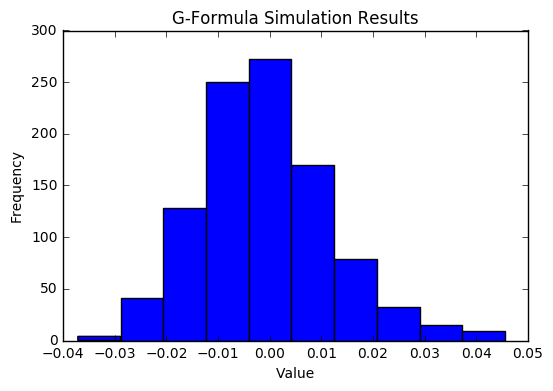

In [49]:
%matplotlib inline
plt.hist(results_g_formula)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

(array([   1.,    1.,    1.,    1.,  992.,    0.,    1.,    1.,    0.,    2.]),
 array([-0.31307606, -0.24472614, -0.17637623, -0.10802631, -0.03967639,
         0.02867353,  0.09702344,  0.16537336,  0.23372328,  0.3020732 ,
         0.37042311]),
 <a list of 10 Patch objects>)

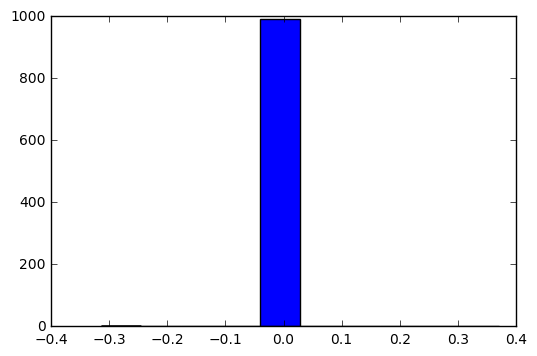

In [41]:
plt.hist(results_dr_estimator)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

In [71]:
plotly.tools.set_credentials_file(username='mbreitmeyer', api_key='Jfc79CurOmlfLyFufhnP')

fig = plt.figure()
data = [go.Histogram(x = results_g_formula)]
py.iplot(data)


High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mbreitmeyer/0 or inside your plot.ly account where it is named 'plot from API'


In [86]:
fig = plt.figure()
data = [go.Histogram(x = results_dr_estimator)]
py.iplot(data)

In [94]:
trace1 = go.Histogram(
    x=results_g_form_df.difference,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_dr_bin_df.difference,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.05, 0.05]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

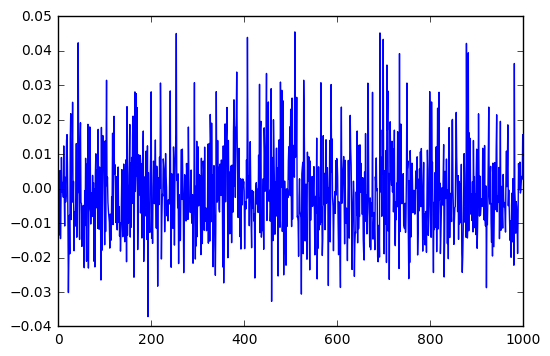

In [42]:
plt.plot(results_g_formula)

In [96]:
results_g_form_df

trace1 = go.Scatter(
    x=results_g_form_df.difference,
    name='G Form'
)
trace2 = go.Scatter(
    x=results_dr_bin_df.difference,
    name='LR DR'
)
data = [trace1, trace2]
layout = go.Layout(xaxis = dict(range = [-0.1, 0.1]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

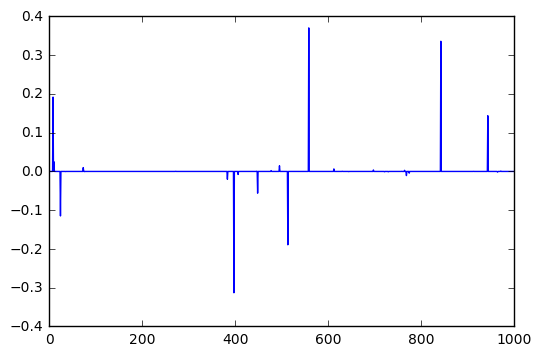

In [43]:
plt.plot(results_dr_estimator)